In [5]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [43]:
with open('tda_train_part.json', 'r') as file:
    data = json.load(file)

In [44]:
images = np.array([el[0] for el in data])
labels_MF = np.array([el[1] for el in data])
labels_BP = np.array([el[2] for el in data])
labels_CC = np.array([el[3] for el in data])

Classes are highly imbalanced, most of them are almost constant zero. To battle this, we aim to discard some of the least interesting labels.

In [46]:
class_counts = np.sum(labels_BP, axis=0)
selected_classes = np.where(class_counts >= 250)[0]
selected_classes

array([  57,   61,   67,  155,  192,  322,  345,  346,  363,  525,  534,
        542,  543,  546,  552,  584,  623,  637,  744,  767,  786,  808,
        864,  897,  934,  956, 1035, 1075, 1095, 1110, 1198, 1200, 1247,
       1294, 1319, 1326, 1350, 1368, 1440, 1506, 1514, 1516, 1541, 1596,
       1668, 1678, 1707, 1732, 1844, 1871, 1872])

In [47]:
labels_BP = labels_BP[:, selected_classes]

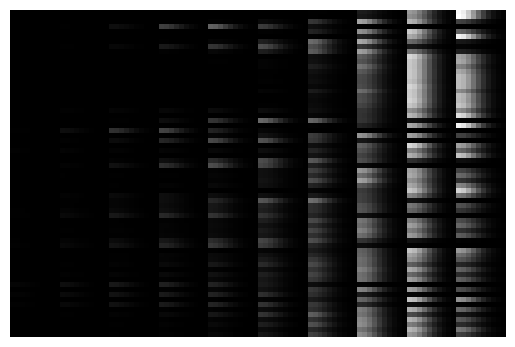

In [10]:
plt.imshow(np.array(images[13]), cmap='gray')
plt.axis('off')
plt.show()

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = TensorDataset(torch.Tensor(images), torch.Tensor(labels_BP)) # Here we handle BP only, changeable to MF or CC.

batch_size = 64

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:
with open('tda_valid.json', 'r') as file:
    data_val = json.load(file)
images_val = np.array([el[0] for el in data_val])
labels_MF_val = np.array([el[1] for el in data_val])
labels_BP_val = np.array([el[2] for el in data_val])[:, selected_classes]
labels_CC_val = np.array([el[3] for el in data_val])

In [18]:
dataset_val = TensorDataset(torch.Tensor(images_val), torch.Tensor(labels_BP_val))

val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [49]:
num_classes = labels_BP.shape[1]
img_size = (images.shape[1], images.shape[2])

In [50]:
class CNN1D(nn.Module):
    def __init__(self, input_size=img_size[1], num_classes=num_classes):
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=img_size[0], out_channels=64, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(128 * (input_size // 4), 256)
        self.fc2 = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [51]:
model = CNN1D().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [57]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        outputs = model(images)

        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)

        labels = labels.to(device)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.numel()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Epoch [10/100], Loss: 0.0510
Epoch [20/100], Loss: 0.0443
Epoch [30/100], Loss: 0.0298
Epoch [40/100], Loss: 0.0260
Epoch [50/100], Loss: 0.0365
Epoch [60/100], Loss: 0.0284
Epoch [70/100], Loss: 0.0233
Epoch [80/100], Loss: 0.0265
Epoch [90/100], Loss: 0.0233
Epoch [100/100], Loss: 0.0325
Validation Accuracy: 95.68%


In [54]:
from calc_f1_max import count_f1_max

In [56]:
with open('tda_test.json', 'r') as file:
    data_test = json.load(file)
images_test = np.array([el[0] for el in data_test])
labels_MF_test = np.array([el[1] for el in data_test])
labels_BP_test = np.array([el[2] for el in data_test])[:, selected_classes]
labels_CC_test = np.array([el[3] for el in data_test])
dataset_test = TensorDataset(torch.Tensor(images_test), torch.Tensor(labels_BP_test))

test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [59]:
model.eval()
total_f1 = 0
num_batches = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.to(device)

        outputs = model(images)

        probs = torch.sigmoid(outputs)

        num_batches += 1
        total_f1 += count_f1_max(probs.cpu().numpy(), labels.cpu().numpy())

print(f"F1_max on Test: {total_f1 / num_batches:.2f}")

F1_max on Test: 0.51
